In [1]:
%load_ext autotime
%matplotlib inline
import sys
sys.path.append('/Users/pradap/Documents/Research/Python-Package/anhaid/py_entitymatching/')

This demo notebook illustrates how to match two tables using Magellan. Our goal is to come up with a workflow to match DBLP and ACM datasets. Specifically, we want to achieve precision greater than 95% and get recall as high as possible. The datasets contain information about the conference papers published in top database conferences. 

First, we need to import the Magellan package as follows:

In [2]:
# Import libraries
import os
import pandas as pd
import py_entitymatching as em
import py_stringsimjoin as ssj
import qgrid
import matplotlib.pyplot as plt

time: 1.46 s


Matching two tables typically consists of the following four steps:
1. Loading the input tables
2. Exploring and cleaning the input tables
3. Blocking the input tables to get a candidate set
4. Matching the tuple pairs in the candidate set

# 1. Loading the input tables

We begin by loading the input tables.

In [3]:
dblp_dataset_path = os.sep.join(['..', 'DBLP_ACM', 'DBLP_cleaned.csv'])
acm_dataset_path = os.sep.join(['..', 'DBLP_ACM', 'ACM_cleaned.csv'])

time: 1.23 ms


In [4]:
# Load csv files as dataframes and set the key attribute in the dataframe
A = em.read_csv_metadata(dblp_dataset_path, key='id')
B = em.read_csv_metadata(acm_dataset_path, key='id')

time: 24.8 ms


In [5]:
print('Number of tuples in A: ' + str(len(A)))
print('Number of tuples in B: ' + str(len(B)))
print('Number of tuples in A X B (i.e the cartesian product): ' + str(len(A)*len(B)))

Number of tuples in A: 2616
Number of tuples in B: 2294
Number of tuples in A X B (i.e the cartesian product): 6001104
time: 2.27 ms


In [6]:
A.head(2)

,id,title,authors,venue,year
0,journals/sigmod/Mackay99,Semantic Integration of Environmental Models for Application to Global Information Systems and D...,D. Scott Mackay,SIGMOD Record,1999
1,conf/vldb/PoosalaI96,Estimation of Query-Result Distribution and its Application in Parallel-Join Load Balancing,"Viswanath Poosala, Yannis E. Ioannidis",VLDB,1996


time: 14.1 ms


In [7]:
B.head(2)

,id,title,authors,venue,year
0,304586,The WASA2 object-oriented workflow management system,"Gottfried Vossen, Mathias Weske",International Conference on Management of Data,1999
1,304587,A user-centered interface for querying distributed multimedia databases,"Isabel F. Cruz, Kimberly M. James",International Conference on Management of Data,1999


time: 8.82 ms


In [8]:
# Display the key attributes of table A and B.
em.get_key(A), em.get_key(B)

('id', 'id')

time: 2.34 ms


In [9]:
# If the tables are large we can downsample the tables like this
A1, B1 = em.down_sample(A, B, 500, 1, show_progress=False)
# But for the demo, we will use the entire table A and B

time: 1.12 s


In [10]:
len(A1), len(B1)

(487, 500)

time: 2.64 ms


# 2. Exploring and cleaning the input tables

In the next step, we explore, understand and clean the input tables.

In [11]:
# Profile the input DBLP dataset
ssj.profile_table_for_join(A)

,Unique values,Missing values,Comments
Attribute,,,
id,2616 (100.0%),0 (0.0%),This attribute can be used as a key attribute.
title,2521 (96.37%),0 (0.0%),
authors,2316 (88.53%),0 (0.0%),
venue,5 (0.19%),0 (0.0%),
year,10 (0.38%),0 (0.0%),


time: 37.6 ms


In [12]:
# Profile the input ACM dataset
ssj.profile_table_for_join(B)

,Unique values,Missing values,Comments
Attribute,,,
id,2294 (100.0%),0 (0.0%),This attribute can be used as a key attribute.
title,2230 (97.21%),0 (0.0%),
authors,2009 (87.58%),14 (0.61%),Joining on this attribute will ignore 14 (0.61%) rows.
venue,5 (0.22%),0 (0.0%),
year,10 (0.44%),0 (0.0%),


time: 34.7 ms


In [13]:
# Explore the input DBLP dataset
# qgrid.show_grid(A.sample(30, random_state=0))

time: 710 µs


In [14]:
# Explore the input ACM dataset
# qgrid.show_grid(B.sample(30, random_state=0))

time: 870 µs


We observe that that the 'authors' column in DBLP dataset contains '?' to represent the missing values. We will replace it with NaN to uniformly represent missing values.

In [15]:
# Observe that the authors have some ? replace with NaN
A.replace({'authors':{'?':pd.np.NaN}}, inplace=True)

time: 2.97 ms


Now, let us check the number of papers published across different conferences.

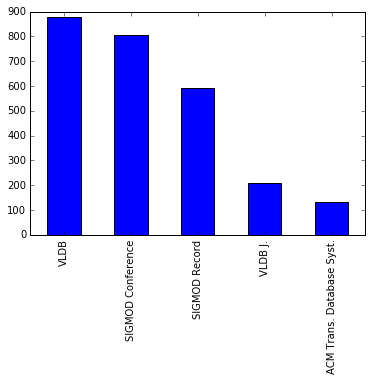

time: 297 ms


In [16]:
fig, ax = plt.subplots()
A['venue'].value_counts().plot(ax=ax, kind='bar')

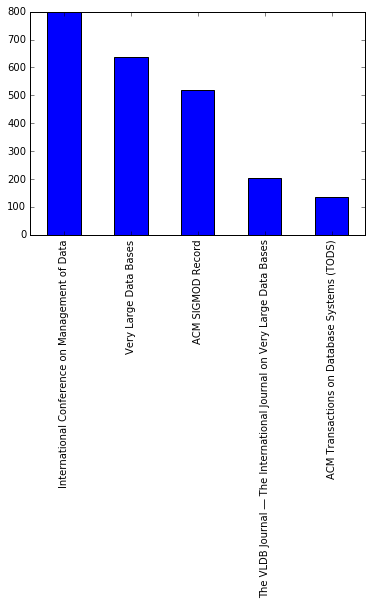

time: 260 ms


In [17]:
fig, ax = plt.subplots()
B['venue'].value_counts().plot(ax=ax, kind='bar')

We observe that the 'venue' column has different names representing the same conference. We will normalize the names in the 'venue' column across the two datasets.

In [18]:
# Normalize attr. values
B.replace({'venue':{
            'The VLDB Journal — The International Journal on Very Large Data Bases':'VLDB J.',
            'Very Large Data Bases': 'VLDB',
            'ACM SIGMOD Record': 'SIGMOD Record'
        }}, inplace=True)

time: 3.25 ms


# 3. Blocking to create candidate tuple pairs

Before we do the matching, we would like to remove the obviously non-matching tuple pairs from the input tables. This would reduce the number of tuple pairs considered for matching. 

Magellan provides four different blockers: (1) attribute equivalence, (2) overlap, (3) rule-based, and (4) black-box. Refer to [api reference] for more details. The user can mix and match these blockers to form a blocking sequence 
applied to input tables.

For the matching problem at hand, we know that two conference papers published in different years cannot match. So, we decide to apply an attribute equivelance blocker on the 'year' attribute. 

In [19]:
# Plan
# A, B ------ attribute equivalence [year] -----> C1

time: 566 µs


In [20]:
# Create attribute equivalence blocker
ab = em.AttrEquivalenceBlocker()
# Block tables using 'year' attribute: same year then include in the canidate set
C1 = ab.block_tables(A, B, 'year', 'year', 
                   l_output_attrs=['title', 'authors', 'year'],
                   r_output_attrs=['title', 'authors', 'year']
                   )

time: 303 ms


In [21]:
# Check the number of rows in C1
len(C1)

601284

time: 2.71 ms


In [22]:
# Display first two rows from C1
C1.head(2)

,_id,ltable_id,rtable_id,ltable_title,ltable_authors,ltable_year,rtable_title,rtable_authors,rtable_year
0,0,journals/sigmod/Mackay99,304586,Semantic Integration of Environmental Models for Application to Global Information Systems and D...,D. Scott Mackay,1999,The WASA2 object-oriented workflow management system,"Gottfried Vossen, Mathias Weske",1999
1,1,journals/sigmod/Mackay99,304587,Semantic Integration of Environmental Models for Application to Global Information Systems and D...,D. Scott Mackay,1999,A user-centered interface for querying distributed multimedia databases,"Isabel F. Cruz, Kimberly M. James",1999


time: 13.1 ms


The number of tuple pairs considered for matching is reduced to 601284 (from 6001104), but we would want to make sure that the blocker did not drop any potential matches. We could debug the blocker output in Magellan as follows:

In [23]:
# Debug blocker output
dbg = em.debug_blocker(C1, A, B, output_size=200)

time: 2.61 s


In [24]:
em.filter_rows(A, "id=='journals/sigmod/Hammer01'")

,id,title,authors,venue,year
311,journals/sigmod/Hammer01,Treasurer's Message,Joachim Hammer,SIGMOD Record,2001


time: 10.9 ms


In [25]:
em.filter_rows(B, "id==601859")

,id,title,authors,venue,year
542,601859,Treasurer's message,Joachim Hammer,SIGMOD Record,2002


time: 13.4 ms


From the debug blocker's output we observe that the current blocker drops quite a few potential matches. We would want to update the blocking sequence to avoid dropping these potential matches.

For the considered dataset, we know that for the conference papers to match the author names must overlap between them. We could use overlap blocker for this purpose. Finally, we would want to union the outputs from the attribute equivalence blocker and the overlap blocker to get a consolidated candidate set.

In [26]:
# Updated blocking sequence
# A, B ------ attribute equivalence [year] -----> C1--
#                                                     |----> C
# A, B ------ overlap blocker [authors] --------> C2--

time: 1.04 ms


In [27]:
# Create an overlap blocker
ob = em.OverlapBlocker()
# Apply overlap blocker on 'authors' attribute
C2 = ob.block_tables(A, B, 'authors', 'authors', 
                   l_output_attrs=['title', 'authors', 'year'],
                   r_output_attrs=['title', 'authors', 'year'],
                   show_progress=False
                   )

time: 2.32 s


In [28]:
# Check the number of rows in C2
len(C2)

287414

time: 3.56 ms


In [29]:
# Display first two rows from C2
C2.head(2)

,_id,ltable_id,rtable_id,ltable_title,ltable_authors,ltable_year,rtable_title,rtable_authors,rtable_year
0,0,journals/vldb/LaurentLSV01,304586,Monotonic complements for independent data warehouses,vossen nicolas gottfried dominique jens spyratos laurent lechtenbrger,2001,The WASA2 object-oriented workflow management system,mathias vossen gottfried weske,1999
1,1,journals/sigmod/McClatcheyV97,304586,Workshop on Workflow Management in Scientific and Engineering Applications - Report,mcclatchey vossen richard gottfried,1997,The WASA2 object-oriented workflow management system,mathias vossen gottfried weske,1999


time: 19.9 ms


In [30]:
# Combine blocker outputs
C = em.combine_blocker_outputs_via_union([C1, C2])

time: 1.85 s


In [31]:
# Check the number of rows in the consolidated candidate set.
len(C)

857777

time: 3.18 ms


We observe that the number of tuple pairs considered for matching is increased to 875758 (from 601284). Now let us debug the blocker output again to check if the current blocker sequence is dropping any potential matches.

In [32]:
# Debug again
dbg = em.debug_blocker(C, A, B)

time: 2.97 s


In [33]:
# Display first few rows from the debugger output
dbg.head(3)

,_id,similarity,ltable_id,rtable_id,ltable_title,ltable_authors,ltable_venue,rtable_title,rtable_authors,rtable_venue
0,0,0.555556,journals/sigmod/Dogac02,945727,Guest Editor's Introduction,Asuman Dogac,SIGMOD Record,Guest editor's introduction,Karl Aberer,SIGMOD Record
1,1,0.555556,journals/sigmod/Dogac98,945727,Guest Editor's Introduction,Asuman Dogac,SIGMOD Record,Guest editor's introduction,Karl Aberer,SIGMOD Record
2,2,0.500000,journals/sigmod/Snodgrass98a,641001,Reminiscences on Influential Papers,Richard T. Snodgrass,SIGMOD Record,Reminiscences on influential papers,Kenneth A. Ross,SIGMOD Record


time: 15.6 ms


We observe that the current blocker sequence does not drop obvious potential matches, and we can proceed with the matching step now. A subtle point to note here is, debugging blocker output practically provides a stopping criteria for modifying the blocker sequence.

As a note, it is easy to patch the blocker sequence with a user defined blocker. As an example, if we want to include the tuple pairs that matches the first two digits of a year, then we can write a write a blocker that will take in a function, execute it over an attribute in the input table and then apply attribute equivelence blocking (on the output from the function).

In [34]:
%run demo_blocker.py

time: 2.92 ms


In [35]:
myab = MyBlocker()

def fn(x):
    return x//100

myab.set_blackbox_function(fn)

time: 1.65 ms


In [36]:
C3 = myab.block_tables(A, B, 'year', 'year')

time: 893 ms


In [37]:
C3.sample(10, random_state=0)

,_id,ltable_id,rtable_id,ltable_year,rtable_year
1274180,1274180,conf/vldb/Cuppens96,181564,1996,1994
1339385,1339385,conf/sigmod/LivnyRBCDLMW97a,673143,1997,1995
1454510,1454510,journals/tods/LiuM96,191955,1996,1994
927871,927871,conf/vldb/AmsalegFG95,174640,1995,1994
2565984,2565984,conf/vldb/MeccaCM01,565138,2001,2002
2815928,2815928,journals/sigmod/Mendelzon00,564694,2000,2002
1912787,1912787,conf/vldb/ShashaB02,765240,2002,2000
602983,602983,conf/vldb/GeorgeH98,671170,1998,1998
2698900,2698900,conf/sigmod/BohannonMR01,335455,2001,2000
763495,763495,conf/sigmod/Team99,765531,1999,1998


time: 325 ms


# 4. Matching tuple pairs in the candidate set

In this step, we would want to match the tuple pairs in the candidate set. Specifically, we use learning-based method for matching purposes.

This typically involves the following five steps:

1. Sampling and labeling the candidate set
2. Splitting the labeled data into development and evaluation set
3. Selecting the best learning based matcher using the development set
4. Evaluating the selected matcher using the evaluation set

## 4.1 Sampling and labeling the candidate set

First, we randomly sample 450 tuple pairs for labeling purposes.

In [38]:
# Sample candidate set
S = em.sample_table(C, 450)

time: 314 ms


In [39]:
# Label S and specify the attribute name for the label column
# L = em.label_table(S, 'gold')

time: 640 µs


In [40]:
# Load the pre-labeled data
L = em.read_csv_metadata('../DBLP_ACM/dblp_acm_demo_labels_clean.csv', ltable=A, rtable=B)
# Display the number of rows in the labaled data set
len(L)

415

time: 8.23 ms


## 4.2 Splitting the labeled data into development and evaluation set

In this step, we split the labeled data into two sets: development and evaluation. Specifically, the development set is used to come up with the best learning-based matcher and the evaluation set used to evaluate the selected matcher on unseen data.

In [41]:
# Split the labeled data into development and evaluation set
development_evaluation = em.split_train_test(L, train_proportion=0.7)
development =  development_evaluation['train']
evaluation = development_evaluation['test']

time: 8.2 ms


## 4.3 Select the best learning-based matcher

Selecting the best learning-based matcher typically involves the following steps:
1. Creating a set of learning-based matchers
2. Creating features
3. Extracting feature vectors
4. Selecting the best learning-based matcher using k-fold cross validation
5. Debugging the matcher (and possibly repeat the above steps)

### 4.3.1 Creating a set of learning-based matchers

First, we need to create a set of learning-based matchers. The following matchers are supported in Magellan: (1) decision tree, (2) random forest, (3) naive bayes, (4) svm, (5) logistic regression, and (6) linear regression.

In [42]:
# Create a set of ML-matchers
dt = em.DTMatcher(name='DecisionTree')
svm = em.SVMMatcher(name='SVM')
rf = em.RFMatcher(name='RF')
nb = em.NBMatcher(name='NB')
lg = em.LogRegMatcher(name='LogReg')
ln = em.LinRegMatcher(name='LinReg')

time: 2.47 ms


### 4.3.2 Creating features

Next, we need to create a set of features for the development set. Magellan provides a way to automatically generate features based on the attributes in the input tables. For the purposes of this guide, we use the automatically generated features.

In [43]:
# Generate features
feature_table = em.get_features_for_matching(A, B)

time: 80.6 ms


In [44]:
# List the names of the features generated
feature_table['feature_name']

0             title_title_jac_qgm_3_qgm_3
1         title_title_cos_dlm_dc0_dlm_dc0
2                         title_title_mel
3                    title_title_lev_dist
4                     title_title_lev_sim
5         authors_authors_jac_qgm_3_qgm_3
6     authors_authors_cos_dlm_dc0_dlm_dc0
7                     authors_authors_mel
8                authors_authors_lev_dist
9                 authors_authors_lev_sim
10            venue_venue_jac_qgm_3_qgm_3
11        venue_venue_cos_dlm_dc0_dlm_dc0
12        venue_venue_jac_dlm_dc0_dlm_dc0
13                        venue_venue_mel
14                   venue_venue_lev_dist
15                    venue_venue_lev_sim
16                        venue_venue_nmw
17                         venue_venue_sw
18                          year_year_exm
19                          year_year_anm
20                     year_year_lev_dist
21                      year_year_lev_sim
Name: feature_name, dtype: object

time: 3.49 ms


We observe that there were 22 features generated. As a first step, lets say that we decide to use only 'year' related features.

In [45]:
# Select the year related features
feature_subset_iter1 = feature_table[18:22]

time: 1.19 ms


In [46]:
# List the names of the features selected
feature_subset_iter1['feature_name']

18         year_year_exm
19         year_year_anm
20    year_year_lev_dist
21     year_year_lev_sim
Name: feature_name, dtype: object

time: 3.14 ms


### 4.3.3 Extracting feature vectors

In this step, we extract feature vectors using the development set and the created features.

In [47]:
# Extract feature vectors
feature_vectors_dev = em.extract_feature_vecs(development, 
                            feature_table=feature_subset_iter1, 
                            attrs_after='gold',
                            show_progress=False) 

time: 139 ms


In [48]:
# Display first few rows
feature_vectors_dev.head(3)

,_id,ltable_id,rtable_id,year_year_exm,year_year_anm,year_year_lev_dist,year_year_lev_sim,gold
411,411,journals/vldb/SivasankaranSTPR96,253294,0,0.999499,1.0,0.75,0
192,192,conf/vldb/Kiessling02,565131,1,1.000000,0.0,1.00,0
312,312,journals/sigmod/KuanL99,344853,1,1.000000,0.0,1.00,0


time: 10.4 ms


Next, we might have to impute the feature vectors as it might contain missing values. First, let us check if there are any missing values in the extracted feature vectors.

In [49]:
# Check if the feature vectors contain missing values
# A return value of True means that there are missing values
feature_vectors_dev.isnull().values.any()

False

time: 3.39 ms


### 3.3.4 Selecting the best matcher using cross-validation

Now, we select the best matcher using k-fold cross-validation. For the purposes of this demo, we use five fold cross validation and use 'precision' metric to select the best matcher.

In [50]:
# Select the best ML matcher using CV
result = em.select_matcher([dt, rf, svm, nb, lg, ln], table=feature_vectors_dev, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'gold'],
        k=5,
        target_attr='gold', metric='precision')

time: 137 ms


In [51]:
# Check the cross validation statistics
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x115fe0e80>,5,0.853659,0.756757,0.744186,0.711111,0.674419,0.748026
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x1159e7ba8>,5,0.785714,0.659091,0.675000,0.756098,0.857143,0.746609
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x115fe0588>,5,0.851064,0.771429,0.600000,0.743590,0.767442,0.746705
3,NB,<py_entitymatching.matcher.nbmatcher.NBMatcher object at 0x1159e7780>,5,0.743590,0.673913,0.704545,0.829268,0.794872,0.749238
4,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x1159e79b0>,5,0.769231,0.688889,0.782609,0.714286,0.783784,0.747760
5,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x1159e7278>,5,0.837838,0.729167,0.690476,0.717949,0.767442,0.748574


time: 18.5 ms


### 4.3.5 Debugging matcher

We observe that the best matcher is not getting us to the precision that we expect (i.e > 95%). We debug the matcher to see what might be wrong.

To do this, first we split the feature vectors into train and test.

In [52]:
## Split feature vectors into train and test
train_test = em.split_train_test(feature_vectors_dev, train_proportion=0.5)
train = train_test['train']
test = train_test['test']

time: 8.48 ms


Next, we debug the matcher using GUI. For the purposes of this demo, we use random forest matcher for debugging purposes.

In [53]:
# Debug decision tree using GUI
# em.vis_debug_rf(rf, train, test, 
#         exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'gold'],
#         target_attr='gold')

time: 1.15 ms


From the GUI, we observe that using only 'year' related features result in a lot of false positives. So we decide to use all the features author, title, year and venue in the feature table and for title we write an additional feature using external package 'fuzzywuzzy'.

In [54]:
# Use fuzzywuzzy to add an additional feature for title

## Create a function
from fuzzywuzzy import fuzz
def fuzz_title_title(ltuple, rtuple):
    s1, s2 = ltuple['title'], rtuple['title']
    if pd.isnull(s1) or pd.isnull(s2):
        return pd.np.NaN
    return fuzz.token_sort_ratio(s1, s2)

time: 9.17 ms


In [55]:
# Add the function to feature table
em.add_blackbox_feature(feature_table, 'fuzz_title_title', fuzz_title_title)

True

time: 87 ms


In [56]:
# Select all features from the feature table
feature_subset_iter2 = feature_table

time: 1.09 ms


Now, we repeat extracting feature vectors (this time with updated feature table), imputing table and selecting the best matcher again using cross-validation.

In [57]:
# Get new set of features
feature_vectors_dev = em.extract_feature_vecs(development, feature_table=feature_subset_iter2, attrs_after='gold', 
                                              show_progress=False)

time: 1.22 s


In [58]:
# Check if the feature vectors contain missing values
# A return value of True means that there are missing values
feature_vectors_dev.isnull().values.any()

False

time: 3.66 ms


In [59]:
# Impute feature vectors
feature_vectors_dev = em.impute_table(feature_vectors_dev, 
                exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'gold'],
                strategy='mean')

time: 14.1 ms


In [60]:
# Apply cross validation to find if there is a better matcher
result = em.select_matcher([dt, rf, svm, nb, lg, ln], table=feature_vectors_dev, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'gold'],
        target_attr='gold', metric='f1') 

time: 163 ms


In [61]:
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x115fe0e80>,5,1.000000,0.982456,1.000000,0.984615,0.984615,0.990337
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x1159e7ba8>,5,1.000000,0.966667,0.964286,0.987342,1.000000,0.983659
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x115fe0588>,5,0.819672,0.983607,0.888889,0.851852,0.923077,0.893419
3,NB,<py_entitymatching.matcher.nbmatcher.NBMatcher object at 0x1159e7780>,5,0.981818,1.000000,1.000000,0.983051,1.000000,0.992974
4,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x1159e79b0>,5,0.984127,1.000000,0.967742,0.983607,0.968750,0.980845
5,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x1159e7278>,5,1.000000,1.000000,1.000000,0.953846,1.000000,0.990769


time: 15.4 ms


Now, observe the best matcher is achieving the expected precision and we can proceed on to evaluating the best matcher on the unseen data (the evaluation set).

## 4.4 Evaluating the matching output

Evaluating the matching outputs for the evaluation set typically involves the following four steps:
1. Extracting the feature vectors
2. Training matcher using the feature vectors extracted from the development set
3. Predicting the evaluation set using the trained matcher
4. Evaluating the predicted matches

### 4.4.1 Extracting the feature vectors

As before, we extract the feature vectors (using the updated feature table and the evaluation set) and impute it (if necessary).

In [62]:
# Get new set of features
feature_vectors_eval = em.extract_feature_vecs(evaluation, 
                                               feature_table=feature_subset_iter2, 
                                              attrs_after='gold', show_progress=False)

time: 622 ms


In [63]:
# Check if the feature vectors contain missing values
# A return value of True means that there are missing values
feature_vectors_eval.isnull().values.any()

False

time: 5.65 ms


In [64]:
# Impute feature vectors
feature_vectors_eval = em.impute_table(feature_vectors_eval, 
                exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'gold'],
                strategy='mean')

time: 15 ms


### 4.4.2 Training the matcher

Now, we train the matcher using all of the feature vectors from the development set. For the purposes of this guide we use random forest as the selected matcher.

In [65]:
# Train using feature vectors from the development set
rf.fit(table=feature_vectors_dev, 
       exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'gold'], 
       target_attr='gold')


time: 19.9 ms


### 4.4.3 Predicting the matches
Next, we predict the matches for the evaluation set (using the feature vectors extracted from it).

In [66]:
# Predict M 
predictions = rf.predict(table=feature_vectors_eval, 
                         exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'gold'], 
                         append=True, 
                         target_attr='predicted', 
                         inplace=False)

time: 5.52 ms


### 4.4.4 Evaluating the matching output

Finally, we evaluate the predicted outputs

In [67]:
# Evaluate the result
eval_result = em.eval_matches(predictions, 'gold', 'predicted')
em.print_eval_summary(eval_result)

Precision : 97.4% (75/77)
Recall : 100.0% (75/75)
F1 : 98.68%
False positives : 2 (out of 77 positive predictions)
False negatives : 0 (out of 48 negative predictions)
time: 14.6 ms
